# 07. 조절효과 (다중집단) 분석
- 여러집단에 대해서 변수들 간의 구조적 관계를 분석 $\rightarrow$ A집단에서의 영향력의 정도가 B집단에서도 동일한지 분석

    경로계수 및 인자구조의 동일성 여부 검정 필요
    
<br>

## 07.01. 조절효과
- **조절변수 : 변수들 사이의 인과관계에서 상황적으로 유의한 영향을 미치는 변수**
    - 조절변수의 수준에 따라서 경로계수의 크기가 다를 때 조절효과(moderationg effect)가 존재
- 조절변수는 이산형일 수도, 연속형일 수도 있음
- **조절변수가 이산형일 때 $\rightarrow$ 다중집단분석 (multiple group analysis)**
    

<br>

## 07.02. 회귀분석을 이용한 조절효과 검정

<br>

### 집단별 (다중집단 분석)

$$\begin{cases}
Y = a_1 + b_1 X + \epsilon\;\; if\;Group = 1\\
Y = a_2 + b_2 X + \epsilon\;\; if\;Group = 2\\
\end{cases}$$

In [6]:
library(lavaan)
library(sem)
library(semPlot)
library(semptools)
library(psych)
library(tidyverse)

In [7]:
detach("package:sem",unload=TRUE)

Warning message:
"'sem' namespace cannot be unloaded:
  namespace 'sem' is imported by 'semPlot' so cannot be unloaded"


In [8]:
Moderator <- read.csv(paste0(getwd(), "/Data/Moderator.csv"), header = TRUE)
Moderator %>% head

,Group,X,Y
,<int>,<dbl>,<dbl>
1,1,88.88889,88.88889
2,1,96.29630,94.44444
3,1,77.77778,83.33333
4,1,70.37037,66.66667
5,1,77.77778,83.33333
6,1,85.18519,77.77778


In [14]:
library(lm.beta)
library(tidymodels)

In [16]:
Moderator.1.fit <- lm(Y ~ X, data = filter(Moderator, Group == 1))
Moderator.1.beta <- lm.beta(Moderator.1.fit)
tidy(Moderator.1.beta)

term,estimate,std_estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),35.3591240,NA,2.55918410,13.81656,6.979145e-38
X,0.4990429,0.5238457,0.03318396,15.03868,1.374755e-43


In [17]:
Moderator.2.fit <- lm(Y ~ X, data = filter(Moderator, Group == 2))
Moderator.2.beta <- lm.beta(Moderator.2.fit)
tidy(Moderator.2.beta)

term,estimate,std_estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),16.0621218,NA,3.73190504,4.304001,2.278014e-05
X,0.6952368,0.6439261,0.04785196,14.528908,1.583249e-36


* Group이 1일 때 $\hat{b} = 0.499$, 2일 때 $\hat{b}=0.685$
- 가설 $H_0 = b_1 = b_2$가 기각되면 조정효과가 존재하며, 이에 대한 검정은 z-통계량을 이용

$$z_b = {{\hat{b_1} - \hat{b_2}}\over{\sqrt{SE^2_{\hat{b}_1}+SE^2_{\hat{b}_2}}}}$$

- 검정결과, z-통계량이 통계적으로 유의 $\rightarrow$ 집단 2에서 강도가 집단 1에서의 강도가 더 큼

In [18]:
b1 <- 0.499; b2 <- 0.695;
SE_b1 <- 0.033; SE_b2 <- 0.049

z_value <- (b1 - b2) / (sqrt(SE_b1^2 + SE_b2^2))
z_value

[1] -3.317748

In [21]:
p_value <- 2 * (1 - pnorm(abs(z_value)))
p_value

[1] 0.0009074641

<br>

### 가변수를 이용하는 방법

$$Z=\begin{cases}
1,\;\;if\;Group=1,\\
2,\;\;if\;Group=2\\
\end{cases}$$

<br>

$$Y = a + b X + c Z + d XZ + \epsilon$$

<br>

- $a = a_2, b = b_2, c = a_1 - a_2, d = b_1 - b_2$의 관계가 성립
    - 가설 $H_0:b_1 = b_2$에 대한 검정은 가설 $H_0:d=0$을 검정하는 것과 동일

<br>

- 가변수 Z 생성

In [22]:
# Dummy Variable
Moderator <- Moderator %>% mutate(Z = ifelse(Group == 1, 1, 0))

- 설명변수 X와 가변수 Z를 곱하여 상호작용 변수 생성

In [ ]:
# Interaction Variable
Moderator <- Moderator %>% mutate(X_Z = X * Z)

- 상호작용 효과의 추정치는 통계적으로 유의 $\rightarrow$ X와 Y 사이의 인과관계에 있어서 Group에 의한 조절효과가 존재

In [23]:
Moderator.fit <- lm(Y ~ X + Z + X_Z, Moderator)
Moderator.beta <- lm.beta(Moderator.fit)
tidy(Moderator.beta)

term,estimate,std_estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),16.0621218,NA,3.95643291,4.059748,5.341999e-05
X,0.6952368,0.6979180,0.05073095,13.704392,6.010593e-39
Z,19.2970022,0.5681345,4.67563986,4.127136,4.015659e-05
X_Z,-0.1961939,-0.4656384,0.06014517,-3.262007,1.148069e-03


<br>

## 07.03. 잠재변수가 없는 모형

<br>

### 기본모형에 대한 적합도 평가

<br>

#### `sem()`의 `group`변수에 조절변수 (Group)을 입력

In [50]:
Customer <- read.csv(paste0(getwd(), "/Data/Customer.csv"), header = TRUE)
Customer %>% head

,Group,Expect,Quality,Value,Satisfact,Complaint,Loyalty
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>
1,1,85.18519,88.88889,88.88889,96.29630,0,77.77778
2,1,92.59259,96.29630,94.44444,100.00000,0,44.44444
3,1,77.77778,77.77778,83.33333,70.37037,0,77.77778
4,1,70.37037,70.37037,66.66667,70.37037,0,44.44444
5,1,77.77778,77.77778,83.33333,81.48148,0,66.66667
6,1,81.48148,85.18519,77.77778,77.77778,0,77.77778


In [51]:
Customer.A <- "
    # regression
    Quality ~ Expect
    Value ~ Expect + Quality
    Satisfact ~ Expect + Quality + Value
    Loyalty ~ Expect + Quality + Satisfact
"

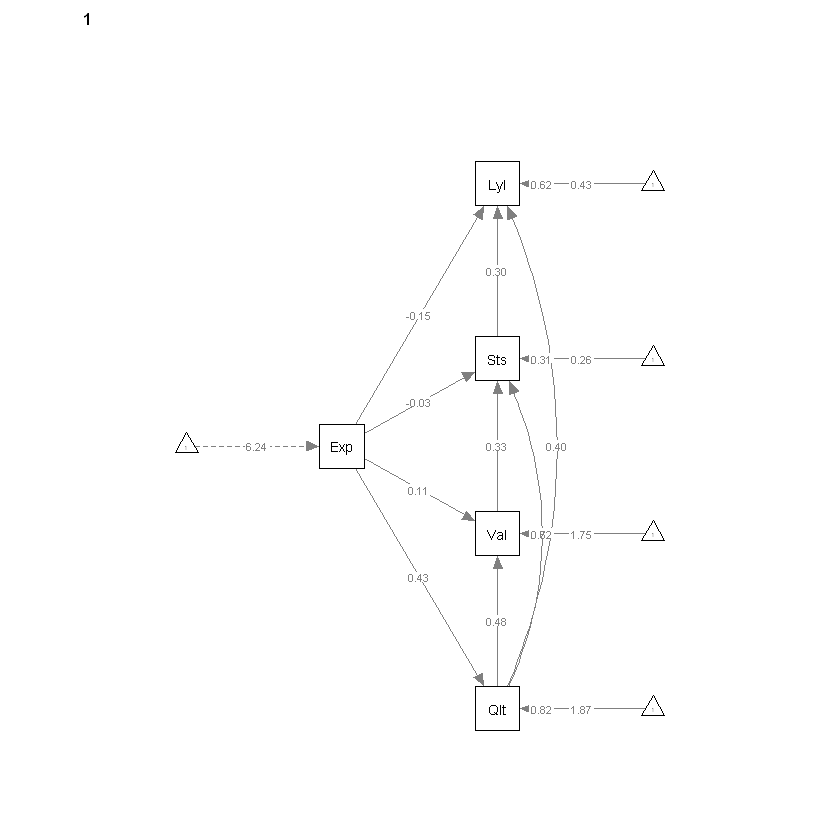

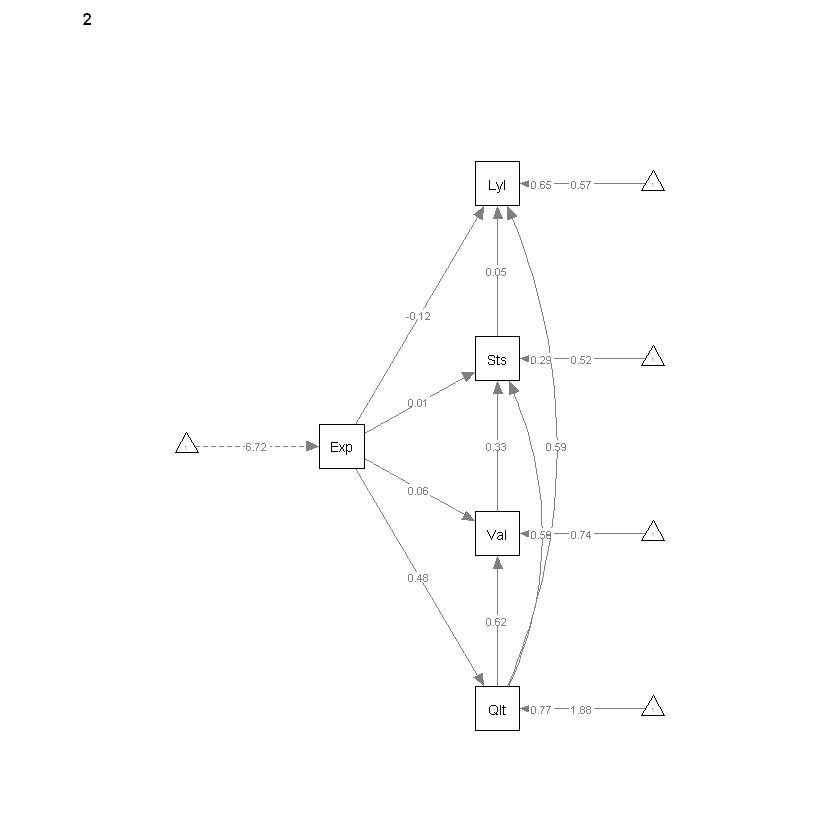

In [52]:
Cus_Multi.A.fit <- sem(Customer.A, Customer, group = "Group")
semPaths(Cus_Multi.A.fit, whatLabels = "std", style = "lisrel", rotation = 2)

- 적합도가 우수한 수준

In [53]:
tidy(fitMeasures(Cus_Multi.A.fit)) %>%
    filter(names %in% c("chisq", "df", "gfi", "agfi", "cfi", "tli", "rmsea", "srmr"))

Warning message:
"'tidy.numeric' is deprecated.
See help("Deprecated")"


names,x
<chr>,<lvn.vctr>
chisq,3.557511303
df,2.000000000
cfi,0.999234594
tli,0.992345938
rmsea,0.041600098
srmr,0.007954207
gfi,0.999896477
agfi,0.997929549


- 계수 추정치 출력

In [54]:
# summary(Cus_Multi.A.fit, fit.measure = T, rsquare = T, standardized = T)$pe 

<br>

### 구조계수 제약모형에 대한 적합도 평가
- **비제약모형 : 집단별 경로계수 및 공분산에 대하여 어떤 동일성 가정도 하지 않은 모형**
- **제약모형 : 일부 경로계수 또는 공분산에 대하여 동일성 가정**

<br>

#### 집단 간 회귀계수들이 모두 동일하다는 제약모형 $\rightarrow$ `sem()`의 `group.equal`에 `c("regressions")`를 입력

In [55]:
Cus_Multi.B.fit <- sem(Customer.A, Customer, group = "Group", group.equal = c("regressions"), estimator = "WLS")

In [56]:
tidy(fitMeasures(Cus_Multi.B.fit)) %>%
    filter(names %in% c("chisq", "df", "gfi", "agfi", "cfi", "tli", "rmsea", "srmr"))

Warning message:
"'tidy.numeric' is deprecated.
See help("Deprecated")"


names,x
<chr>,<lvn.vctr>
chisq,22.73596158
df,11.00000000
cfi,0.96351411
tli,0.93366203
rmsea,0.04874609
srmr,0.04401376
gfi,0.99968107
agfi,0.99884026


- anova함수를 사용하여 두 모형의 적합도 차이에 대한 카이제곱검정을 쉽게 수행

In [61]:
anova(Cus_Multi.B.fit, Cus_Multi.A.fit)

,Df,AIC,BIC,Chisq,Chisq diff,RMSEA,Df diff,Pr(>Chisq)
,<int>,<lgl>,<lgl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>
Cus_Multi.A.fit,2,NA,NA,3.557511,NA,NA,NA,NA
Cus_Multi.B.fit,11,NA,NA,22.735962,19.17845,0.0501318,9,0.02371761


<br>

- 비제약모형의 적합도는 우수해야 함 
    - 연구자가 설정한 기본모형이 모든 집단의 데이터에 대하여 잘 적합되는 것을 의미
- 인과관계를 나타내는 구조계수들이 두 집단 간에 서로 다르다면, 조절효과가 존재한다는 의미
    - 구조계수 제약모형의 적합도는 비제약모형의 적합도와 큰 차이를 가져야 함
    - 구조계수 제약모형의 모든 구조계수(회귀계수)들이 집단 간에 동일하다고 가정하는 모형이기 때문
    
<br>


| 구분 | $\chi^2$ | df | p-값 | NFI | IFI | RFI | TLI |
| - | - | - | - | - | - | - | - | 
| 구조계수 제약모형 | 22.736 | 11 | - | 0.933 | 0.965 | 0.879 | 0.934 |
| 비제약모형 (기본모형) | 3.533 | 2 | - | 0.990 | 0.995 | 0.995 | 0.952 |
| | 
| 차이 ($\Delta$) | 19.203 | 9 | 0.024 | -0.057 | -0.030 | -0.116 | -0.018 |

<hr>


- 두 모형의 $\chi^2$값에 대한 차이는 19.203이며, 자유도의 차이는 9
- **이에 대응하는 p-값은 0.024로서 통계적으로 유의 $\rightarrow$ 조절효과가 존재 (구조계수 제약모형과 비제약모형의 적합도가 다름)**

#### 적어도 몇 개의 구조계수들은 두 집단 간에 서로 다르다는 결론

<br>

- **회귀계수 추정치들이 모두 두 집단에서 동일하게 출력 (집단 간 회귀계수가 동일하다는 제약이 들어갔기 때문)** 

In [64]:
summary(Cus_Multi.B.fit, fit.measure = T, rsquare = T, standardized = T)$pe %>%
    filter(op == "~")

lhs,op,rhs,block,group,label,exo,est,se,z,pvalue,std.lv,std.all,std.nox
<chr>,<chr>,<chr>,<int>,<int>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Quality,~,Expect,1,1,.p1.,0,0.53480848,0.04463019,11.9831092,0.000000e+00,0.53480848,0.436277267,0.0333649653
Value,~,Expect,1,1,.p2.,0,0.10351071,0.03838920,2.6963495,7.010407e-03,0.10351071,0.084741314,0.0064807204
Value,~,Quality,1,1,.p3.,0,0.53419158,0.03832952,13.9368196,0.000000e+00,0.53419158,0.536096083,0.5360960831
Satisfact,~,Expect,1,1,.p4.,0,0.01077386,0.02968242,0.3629711,7.166264e-01,0.01077386,0.008923222,0.0006824170
Satisfact,~,Quality,1,1,.p5.,0,0.57850327,0.03259303,17.7492966,0.000000e+00,0.57850327,0.587342981,0.5873429814
Satisfact,~,Value,1,1,.p6.,0,0.33156224,0.02785776,11.9019715,0.000000e+00,0.33156224,0.335432723,0.3354327229
Loyalty,~,Expect,1,1,.p7.,0,-0.19966054,0.05245217,-3.8065254,1.409328e-04,-0.19966054,-0.112069999,-0.0085707231
Loyalty,~,Quality,1,1,.p8.,0,0.65616520,0.06324654,10.3747211,0.000000e+00,0.65616520,0.451487810,0.4514878099
Loyalty,~,Satisfact,1,1,.p9.,0,0.27143766,0.06429189,4.2219577,2.421896e-05,0.27143766,0.183957276,0.1839572763


<br>

### 개별 계수들에 대한 평가
- **조절효과가 존재하는 것으로 나타남 $\rightarrow$ 어떤 구조계수가 차이를 가지는가 탐색**
- 두 집단 회귀계수의 차이에 대한 검정은 z-통계량을 사용하여 수행

<br>

**회귀계수 추정치 일부**

- **Group A**

| 내생변수 | 설명변수 | 추정치 | 표준화추정치 | p-val | SMC | 
| - | - | - | - | - | - |
| Quality | Expect | 0.534 | 0.429 | <.001 | 0.184 | 
| | 
| Value | Expect | 0.125 | 0.106 | 0.006 | 0.284 | 
|  | Quality | 0.454 | 0.479 | <.001 |  | 

- **Group B**

| 내생변수 | 설명변수 | 추정치 | 표준화추정치 | p-val | SMC | 
| - | - | - | - | - | - |
| Quality | Expect | 0.580 | 0.486 | <.001 | 0.237 | 
| | 
| Value | Expect | 0.072 | 0.056 | 0.307 | 0.420 | 
|  | Quality | 0.665 | 0.619 | <.001 |  | 


- **두 집단 회귀계수 차이**

| 내생변수 | 설명변수 | 추정치 | 표준화추정치 | p-val |
| - | - | - | - | - | 
| Quality | Expect | -0.046 | -0.057 | <.610 | 
| | 
| Value | Expect | 0.050 | 0.043 | 0.529 |
|  | Quality | -0.211 | -0.140 | 0.014 |

<hr>

- **인과관계 'Value $\leftarrow$ Expect'의 경우 Group 1에서의 추정치는 0.125, Group 2에서의 추정치는 0.072**
    - **Group 1에서만 회귀계수가 통계적으로 유의**
    - **추정치의 차이는 0.050으로 크지 않으며, 두 집단 회귀계수의 차이는 통계적으로 유의하지 않음**

<br>

- **인과관계 'Value $\leftarrow$ Quality'의 경우 Group 1에서의 추정치는 0.454, Group 2에서의 추정치는 0.665**
    - **모든 Group에서 회귀계수가 통계적으로 유의**
    - **추정치의 차이는 -0.211으로 크며, 두 집단 회귀계수의 차이는 통계적으로 유의**

<br>

## 07.04. 잠재변수가 있는 모형

<br>

### 기본모형에 대한 적합도 평가

In [66]:
Satisfact <- read.csv(paste0(getwd(), "/Data/Satisfact.csv"), header = TRUE)

In [68]:
Satisfact.B <- "
    # measurement model
    Expect =~ f1_1 + f1_2 + f1_3
    Quality =~ f2_1 + f2_2 + f2_3
    Value =~ f3_1 + f3_2
    Satisfact =~ f4_1 + f4_2 + f4_3
    
    # regression
    Quality ~ Expect
    Value ~ Expect + Quality
    Satisfact ~ Expect + Quality + Value

    # error covariance
    f1_1 ~~ f2_1
    f1_2 ~~ f2_2
    f1_3 ~~ f2_3
"

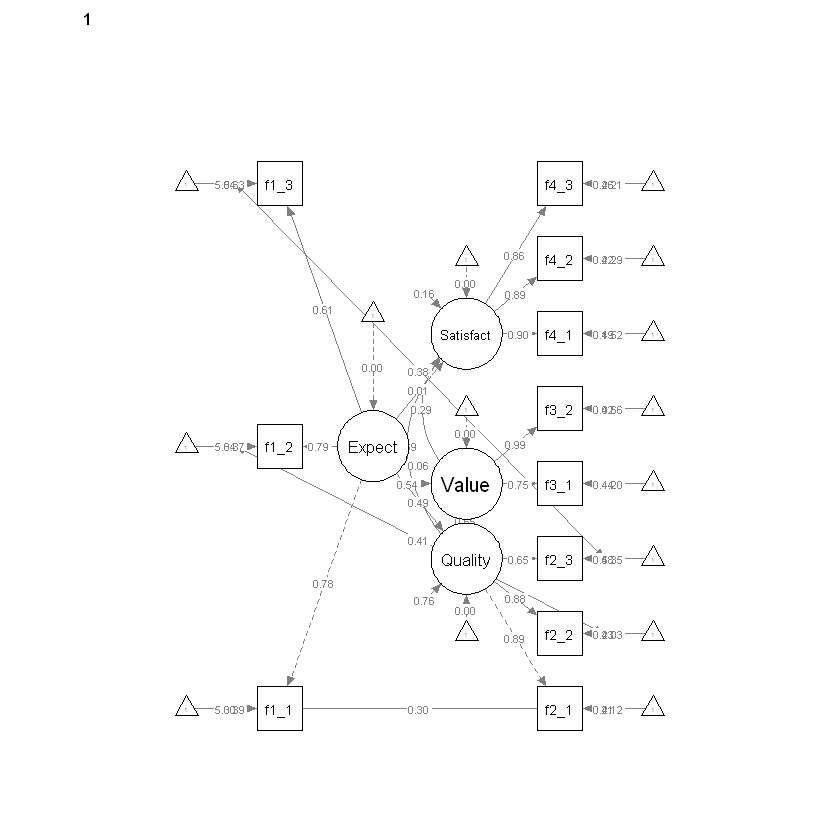

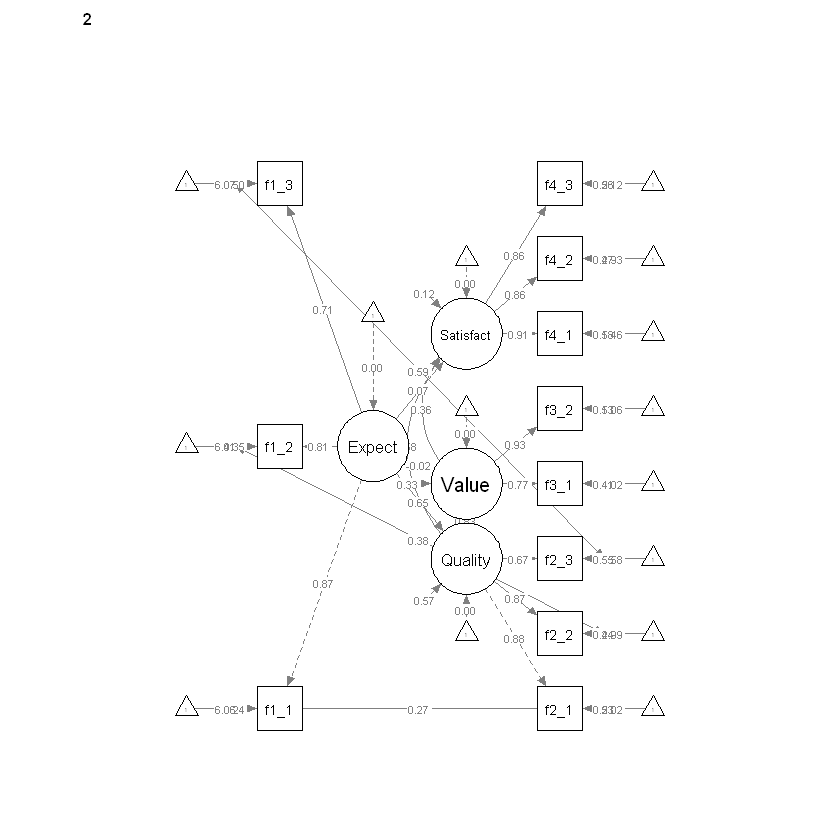

In [72]:
Sat_Multi.A.fit <- sem(Satisfact.B, Satisfact, group = "Group", estimator = "WLS")
semPaths(Sat_Multi.A.fit, whatLabels = "std", style = "lisrel", nCharNodes = 0, rotation = 2)

- 적합도 지수들이 나쁘지 않음

In [73]:
tidy(fitMeasures(Sat_Multi.A.fit)) %>%
    filter(names %in% c("chisq", "df", "gfi", "agfi", "cfi", "tli", "rmsea", "srmr"))

Warning message:
"'tidy.numeric' is deprecated.
See help("Deprecated")"


names,x
<chr>,<lvn.vctr>
chisq,140.88997160
df,70.00000000
cfi,0.91632530
tli,0.86851118
rmsea,0.04749197
srmr,0.07510060
gfi,0.99859433
agfi,0.99690753


- 회귀계수|

In [75]:
# summary(Sat_Multi.A.fit, fit.measures = TRUE, rsquare = TRUE, standardized = TRUE) %>% print

<br>

### 측정계수 제약모형에 대한 적합도 평가 (measurement weights constrained model)
- **측정계수 제약모형 : 두 집단에 대하여 관찰변수와 잠재변수의 관계를 나타내는 인자적재값이 모두 동일하다는 가정**
- **측정계수 비 제약모형 : 두 집단에 대하여 관찰변수와 잠재변수의 관계에 제약이 없음**

<br>

#### 집단 간 인자적재값들이 모두 동일하다는 제약 $\rightarrow$ `sem()`의 `group.equal`을 `c("loadings")`로 입력


In [76]:
Sat_Multi.B.fit<- sem (Satisfact.B, Satisfact, group = "Group", group.equal = c("loadings"), estimator = "WLS")
tidy(fitMeasures(Sat_Multi.B.fit)) %>%
    filter(names %in% c("chisq", "df", "gfi", "agfi", "cfi", "tli", "rmsea", "srmr"))

Warning message:
"'tidy.numeric' is deprecated.
See help("Deprecated")"


names,x
<chr>,<lvn.vctr>
chisq,144.42615500
df,77.00000000
cfi,0.92041380
tli,0.88630543
rmsea,0.04416169
srmr,0.08329010
gfi,0.99855899
agfi,0.99711798


In [77]:
anova(Sat_Multi.B.fit, Sat_Multi.A.fit)

,Df,AIC,BIC,Chisq,Chisq diff,RMSEA,Df diff,Pr(>Chisq)
,<int>,<lgl>,<lgl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>
Sat_Multi.A.fit,70,NA,NA,140.8900,NA,NA,NA,NA
Sat_Multi.B.fit,77,NA,NA,144.4262,3.536183,0,7,0.8313782



| 구분 | $\chi^2$ | df | p-값 | NFI | IFI | RFI | TLI |
| - | - | - | - | - | - | - | - | 
| 구조계수 제약모형 | 144.426 | 77 | - | 0.849 | 0.923 | 0.784 | 0.886 |
| 비제약모형 (기본모형) | 140.890 | 70 | - | 0.853 | 0.920 | 0.769 | 0.869 |
| | 
| 차이 ($\Delta$) | 3.536 | 7 | 0.831 | -0.004 | 0.003 | 0.015 | 0.017 |

<br>

- 두 모형의 $\chi^2$값에 대한 차이는 3.536이며, 자유도의 차이는 7
- **이에 대응하는 p-값은 0.831로서 통계적으로 유의하지 않음 
- 주요 증분 적합도 지수들의 차이도 매우 작음

#### 측정계수 제약모형을 채택 $\rightarrow$ 각 집단에서 잠재변수의 의미가 동일

<br>

- 측정모형의 계수들은 두 집단에서 같게 추정

In [82]:
summary(Sat_Multi.B.fit, fit.measures = TRUE, rsquare = TRUE, standardized = TRUE)$pe %>%
    filter(op == "=~")

lhs,op,rhs,block,group,label,exo,est,se,z,pvalue,std.lv,std.all,std.nox
<chr>,<chr>,<chr>,<int>,<int>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Expect,=~,f1_1,1,1,,0,1.0000000,0.00000000,NA,NA,0.11963333,0.7782990,0.7782990
Expect,=~,f1_2,1,1,.p2.,0,0.9475070,0.04945828,19.15770,0,0.11335342,0.7847356,0.7847356
Expect,=~,f1_3,1,1,.p3.,0,0.8302732,0.04997496,16.61378,0,0.09932834,0.6316569,0.6316569
Quality,=~,f2_1,1,1,,0,1.0000000,0.00000000,NA,NA,0.15955760,0.8906698,0.8906698
Quality,=~,f2_2,1,1,.p5.,0,0.9902009,0.03398779,29.13402,0,0.15799408,0.8744775,0.8744775
Quality,=~,f2_3,1,1,.p6.,0,0.7301155,0.04123754,17.70512,0,0.11649548,0.6265661,0.6265661
Value,=~,f3_1,1,1,,0,1.0000000,0.00000000,NA,NA,0.13695773,0.7750566,0.7750566
Value,=~,f3_2,1,1,.p8.,0,1.1055229,0.05057581,21.85873,0,0.15140991,0.9722237,0.9722237
Satisfact,=~,f4_1,1,1,,0,1.0000000,0.00000000,NA,NA,0.14688114,0.8958579,0.8958579


<br>


- 구조모형의 계수들에 대해서는 집단별로 추정치들이 다름


In [83]:
summary(Sat_Multi.B.fit, fit.measures = TRUE, rsquare = TRUE, standardized = TRUE)$pe %>%
    filter(op == "~")

lhs,op,rhs,block,group,label,exo,est,se,z,pvalue,std.lv,std.all,std.nox
<chr>,<chr>,<chr>,<int>,<int>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Quality,~,Expect,1,1,,0,0.658115369,0.07029749,9.36186196,0.000000e+00,0.493442716,0.493442716,0.493442716
Value,~,Expect,1,1,,0,0.065803510,0.05464627,1.20417207,2.285231e-01,0.057479730,0.057479730,0.057479730
Value,~,Quality,1,1,,0,0.556987678,0.04838391,11.51183743,0.000000e+00,0.648898147,0.648898147,0.648898147
Satisfact,~,Expect,1,1,,0,0.022635897,0.05015193,0.45134650,6.517398e-01,0.018436729,0.018436729,0.018436729
Satisfact,~,Quality,1,1,,0,0.620771550,0.05974067,10.39110516,0.000000e+00,0.674346716,0.674346716,0.674346716
Satisfact,~,Value,1,1,,0,0.327219119,0.04927584,6.64055942,3.124945e-11,0.305111914,0.305111914,0.305111914
Quality,~,Expect,2,2,,0,0.748328443,0.06619352,11.30516147,0.000000e+00,0.651613606,0.651613606,0.651613606
Value,~,Expect,2,2,,0,-0.008250962,0.08346913,-0.09885047,9.212570e-01,-0.007794314,-0.007794314,-0.007794314
Value,~,Quality,2,2,,0,0.749805167,0.10136345,7.39719467,1.389999e-13,0.813436805,0.813436805,0.813436805


<br>

### 구조계수 제약모형에 대한 적합도 평가
- **제약모형 : 일부 경로계수 또는 공분산에 대하여 동일성 가정**
- **비제약모형 : 집단별 경로계수 및 공분산에 대하여 어떤 동일성 가정도 하지 않은 모형**

<br>

#### 집단 간 인자적재값들과 회귀계수들이 모두 동일하다는 제약 $\rightarrow$ `sem()`의 `group.equal`을 `c("loadings", "regressions")`로 입력


In [85]:
Sat_Multi.C.fit<- sem (Satisfact.B, Satisfact, group = "Group", group.equal = c("loadings", "regressions"), estimator = "WLS")
tidy(fitMeasures(Sat_Multi.C.fit)) %>%
    filter(names %in% c("chisq", "df", "gfi", "agfi", "cfi", "tli", "rmsea", "srmr"))

Warning message:
"'tidy.numeric' is deprecated.
See help("Deprecated")"


names,x
<chr>,<lvn.vctr>
chisq,151.93975616
df,83.00000000
cfi,0.91862723
tli,0.89215656
rmsea,0.04301032
srmr,0.08872439
gfi,0.99848476
agfi,0.99718859


In [90]:
anova(Sat_Multi.C.fit, Sat_Multi.B.fit)

,Df,AIC,BIC,Chisq,Chisq diff,RMSEA,Df diff,Pr(>Chisq)
,<int>,<lgl>,<lgl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>
Sat_Multi.B.fit,77,NA,NA,144.4262,NA,NA,NA,NA
Sat_Multi.C.fit,83,NA,NA,151.9398,7.513601,0.02367685,6,0.2759457


<br>

- **만약 잠재변수들 간의 인과관계를 나타내는 구조계수들이 두 집단 간에 서로 다르다면, 조절효과가 존재한다는 의미**
    - 이 경우, 구조계수 제약모형의 적합도는 좋지 않음
    - 측정계수 제약모형과 구조계수 제약모형의 적합도 차이도 큼

<br>

| 구분 | $\chi^2$ | df | p-값 | NFI | IFI | RFI | TLI |
| - | - | - | - | - | - | - | - | 
| 측정계수 제약모형 | 151.94 | 83 | - | 0.841 | 0.921 | 0.790 | 0.891 |
| 구조계수 제약모형 | 144.426 | 77 | - | 0.849 | 0.923 | 0.784 | 0.886 |
| | 
| 차이 ($\Delta$) | 7.514 | 6 | 0.276 | -0.008 | -0.002 | 0.006 | 0.005 |

<br>

- 두 모형의 $\chi^2$값에 대한 차이는 7.514이며, 자유도의 차이는 6
- 이에 대응하는 p-값은 0.276으로서 통계적으로 유의하지 않음 

#### 두 모형의 적합도는 서로 다르지 않음 $\rightarrow$ 측정계수와 구조계수 모두에서 조절효과가 존재하지 않음 $\rightarrow$ 모든 회귀계수들은 두 집단간에 서로 다르지 않음

<br>

### 개별계수들에 대한 평가

<br>

**회귀계수 추정치 일부**

- **Group A**

| 내생변수 | 설명변수 | 추정치 | 표준화추정치 | p-val | SMC | 
| - | - | - | - | - | - |
| Quality | Expect | 0.658 | 0.493 | <.001 | 0.243 | 
| | 
| Value | Expect | 0.066 | 0.057 | 0.229 | 0.461 | 
|  | Quality | 0.557 | 0.649 | <.001 |  | 
| |
| Satisfact | Expect | 0.023 | 0.018 | 0.652 | 0.843 | 
|  | Quality | 0.621 | 0.674 | <.001 |  | 
|  | Value | 0.327 | 0.305 | <.001 |  | 

- **Group B**

| 내생변수 | 설명변수 | 추정치 | 표준화추정치 | p-val | SMC | 
| - | - | - | - | - | - |
| Quality | Expect | 0.748 | 0.652 | <.001 | 0.425 | 
| | 
| Value | Expect | -0.008 | -0.008 | 0.921 | 0.653 | 
|  | Quality | 0.750 | 0.813 | <.001 |  | 
| |
| Satisfact | Expect | 0.089 | 0.082 | 0.150 | 0.875 | 
|  | Quality | 0.538 | 0.570 | <.001 |  | 
|  | Value | 0.363 | 0.354 | 0.001 |  | 

- **두 집단 회귀계수 차이**

| 내생변수 | 설명변수 | 추정치 | 표준화추정치 | p-val |
| - | - | - | - | - | 
| Quality | Expect | -0.090 | -0.159 | <.350 | 
| | 
| Value | Expect | 0.074 | 0.065 | 0.458 |
|  | Quality | -0.193 | -0.164 | 0.062 |
| |
| Value | Expect | -0.082 | -0.074 | 0.409 |
|  | Quality | 0.083 | 0.104 | 0.513 |
|  | Value | -0.036 | -0.049 | 0.764 |


<hr>

<br>

## 07.05. 상호작용 효과를 이용한 조절효과 분석

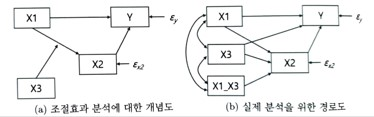

$$\begin{cases}
X_2 = \beta_1 X_1 + \beta_3 + X_3 + \beta_{13} X_1 X_3 + \epsilon_{x_2}\\
Y = \gamma_{1}X_1 + \gamma_2 X_2 + \gamma_3 X_3 + \epsilon_y\\
\end{cases}$$

In [92]:
Interaction <- read.csv(paste0(getwd(), "/Data/Interaction.csv"), header = TRUE)
Interaction <- Interaction %>% mutate(X1_X3 = X1 * X3)

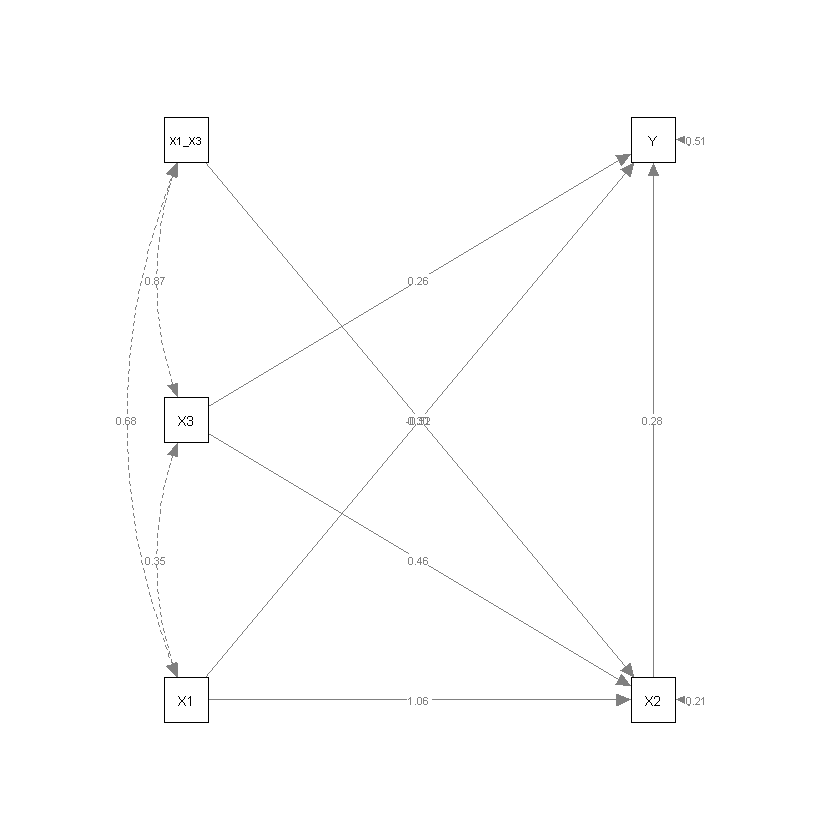

In [93]:
Interaction.A <- "
    # regression
    X2 ~ X1 + X3 + X1_X3
    Y ~ X1 + X2 + X3
"
Interaction.A.fit <- sem(Interaction.A, Interaction)
semPaths(Interaction.A.fit, whatLabels = "std", style = "lisrel", nCharNodes = 0, rotation = 2)

In [94]:
tidy(fitMeasures(Interaction.A.fit)) %>%
    filter(names %in% c("chisq", "df", "gfi", "agfi", "cfi", "tli", "rmsea", "srmr"))

Warning message:
"'tidy.numeric' is deprecated.
See help("Deprecated")"


names,x
<chr>,<lvn.vctr>
chisq,0.484655751
df,1.000000000
cfi,1.000000000
tli,1.018596794
rmsea,0.000000000
srmr,0.003529478
gfi,0.999414694
agfi,0.991220410


In [97]:
summary(Interaction.A.fit, fit.measures = T, rsquare = T, standardized = T) %>% print

lavaan 0.6.16 ended normally after 1 iteration

  Estimator                                         ML
  Optimization method                           NLMINB
  Number of model parameters                         8

  Number of observations                            90

Model Test User Model:
                                                      
  Test statistic                                 0.485
  Degrees of freedom                                 1
  P-value (Chi-square)                           0.486

Model Test Baseline Model:

  Test statistic                               200.980
  Degrees of freedom                                 7
  P-value                                        0.000

User Model versus Baseline Model:

  Comparative Fit Index (CFI)                    1.000
  Tucker-Lewis Index (TLI)                       1.019

Loglikelihood and Information Criteria:

  Loglikelihood user model (H0)               -456.453
  Loglikelihood unrestricted model (H1)       -456

<br>

**상호작용 모형 계수 추정치**

| 내생변수 | 설명변수 | 추정치 | 표준화추정치 | p-val | SMC |
| - | - | - | - | - | - | 
| X2 | X1 | 1.268 | 1.063 | <.001 | 0.787 | 
|  | X3 | 0.248 | 0.463 | <.001 | | 
|  | X1 * X3 | -0.017 | -0.518 | 0.004 |  | 
| | 
| Y | X1 | 0.761 | 0.297 | 0.054 | 0.494 | 
|  | X1 | 0.603 | 0.281 | 0.072 |  | 
|  | X1 | 0.305 | 0.265 | 0.001 | | 

<br>

- $X_2 \leftarrow X_1$의 계수추정치는 1.268이며, 통계적으로 유의 $\rightarrow$ 설명변수 $X_1$과 내생변수 $X_2$는 양의 인과관계
- $X_2 \leftarrow X1_X3$의 계수추정치는 통계적으로 유의 $\rightarrow$ 조절효과가 존재
    - 상호작용 효과에 대한 부호가 음수이므로, $X_3$이 커질수록, $X_1$과 $X_2$사이의 인과관계의 강도가 작아짐